# Data Cleaning - Coaches

In [1]:
import pandas as pd
from utils import *
import os

df = pd.read_csv('../data/raw/coaches.csv')
init_num_rows = df.shape[0]
df.head()

,coachID,year,tmID,lgID,stint,won,lost,post_wins,post_losses
0,adamsmi01w,5,WAS,WNBA,0,17,17,1,2
1,adubari99w,1,NYL,WNBA,0,20,12,4,3
2,adubari99w,2,NYL,WNBA,0,21,11,3,3
3,adubari99w,3,NYL,WNBA,0,18,14,4,4
4,adubari99w,4,NYL,WNBA,0,16,18,0,0


## Dealing with Missing Values / Features

<Axes: title={'center': 'Number of null values per column'}>

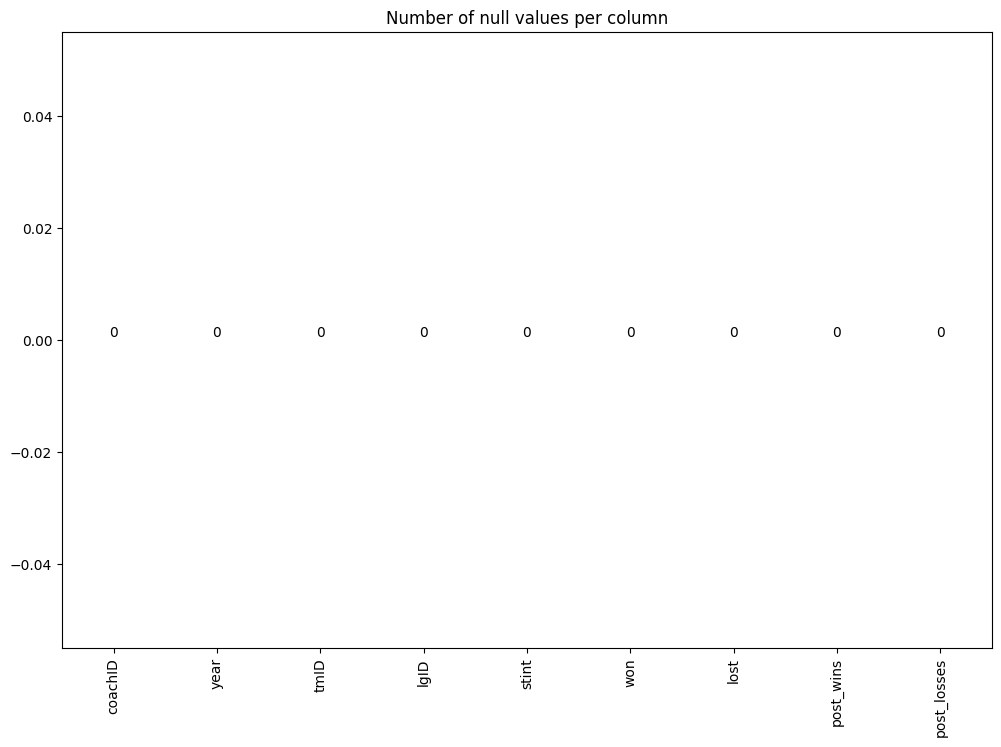

In [2]:
nulls_values_by_column(df)

## Dealing with Duplicate values / Redundant Data

<Axes: title={'center': 'Number of Unique Values Per Column'}>

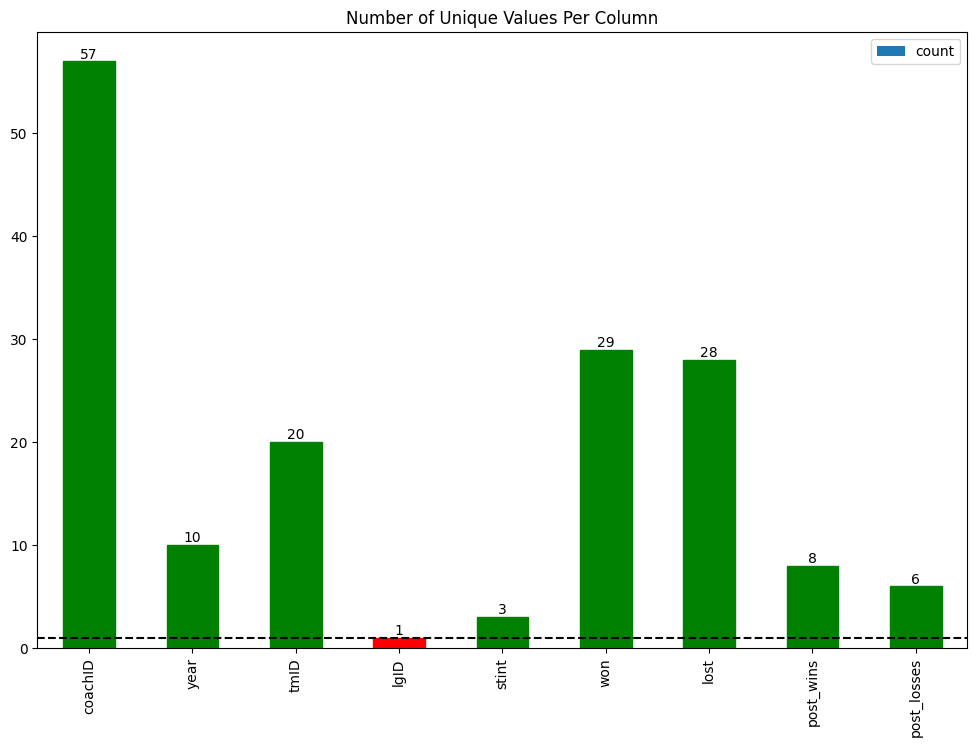

In [3]:
unique_values_by_column(df, 1)

In [4]:
num_columns = len(df.columns)
df = filter_column_uniques(df, 1)
print(f"Removed {num_columns - len(df.columns)} columns that had only one unique value")

Removed 1 columns that had only one unique value


In [5]:
num_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Removed {num_rows - df.shape[0]} repeated rows")

Removed 0 repeated rows


## Outliers and Noise

### Detecting and Removing Outliers using ...

### ... z-score

This is a simple way to detect outliers using the z-score. The z-score is the number of standard deviations away from the mean a data point is. If the absolute value of the z-score is greater than 3, we can flag this data point as an outlier.

Let's take a look at the z-score range using a histogram plot.

<module 'matplotlib.pyplot' from '/opt/homebrew/lib/python3.10/site-packages/matplotlib/pyplot.py'>

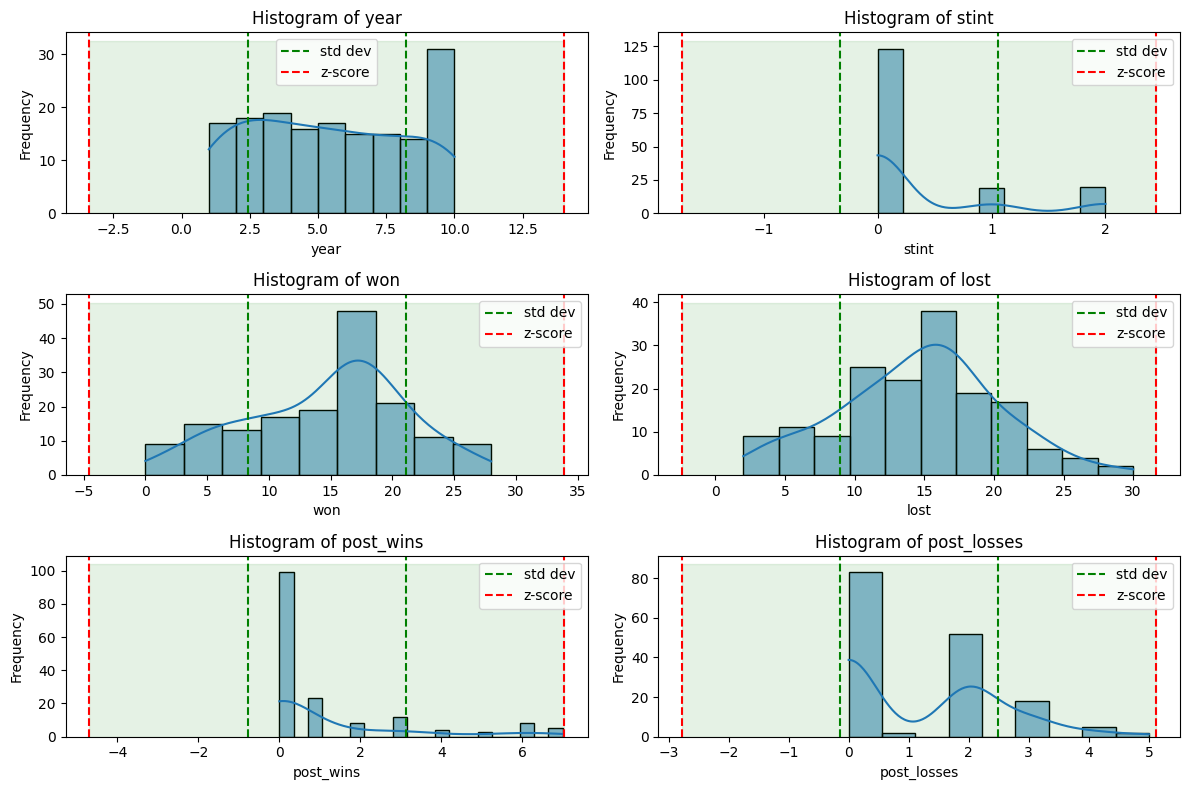

In [6]:
max_zscore = 3
rows2drop = set()
histogram_plot(df, max_zscore)

Now let's use the z-score to detect and remove outliers from the dataset.

In [7]:
rows2drop_zscore = filter_by_zscore(df, max_zscore)
print(f"Removed {len(rows2drop_zscore)} rows with zscore > {max_zscore}")

rows2drop.update(rows2drop_zscore)

Removed 0 rows with zscore > 3


### ... Interquartile Range (IQR)

The interquartile range (IQR) is a measure of statistical dispersion and is calculated as the difference between the 75th and 25th percentiles. It is represented by the formula IQR = Q3 − Q1. The IQR may also be called the midspread or middle 50%. It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.

Let's take a look at the IQR range using a histogram plot.

<module 'matplotlib.pyplot' from '/opt/homebrew/lib/python3.10/site-packages/matplotlib/pyplot.py'>

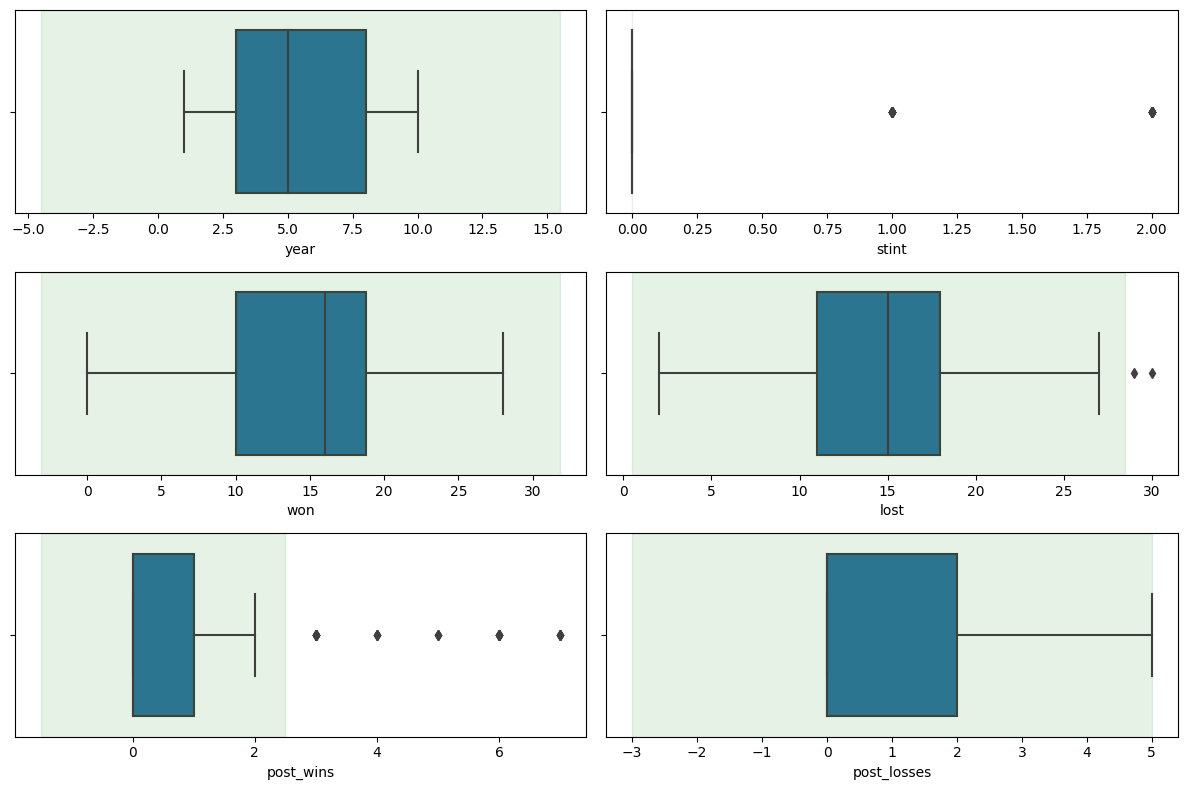

In [8]:
factor = 1.5
iqr_plot(df, factor)

Now let's use the IQR to detect and remove outliers from the dataset.

In [9]:
rows2drop_iqr = filter_by_iqr(df, factor, ['post_wins', 'lost', 'stint'])
print(f"Removed {len(rows2drop_iqr)} rows with factor = {factor}")

rows2drop.update(rows2drop_iqr)

Removed 0 rows with factor = 1.5


### ... Scatter Plot

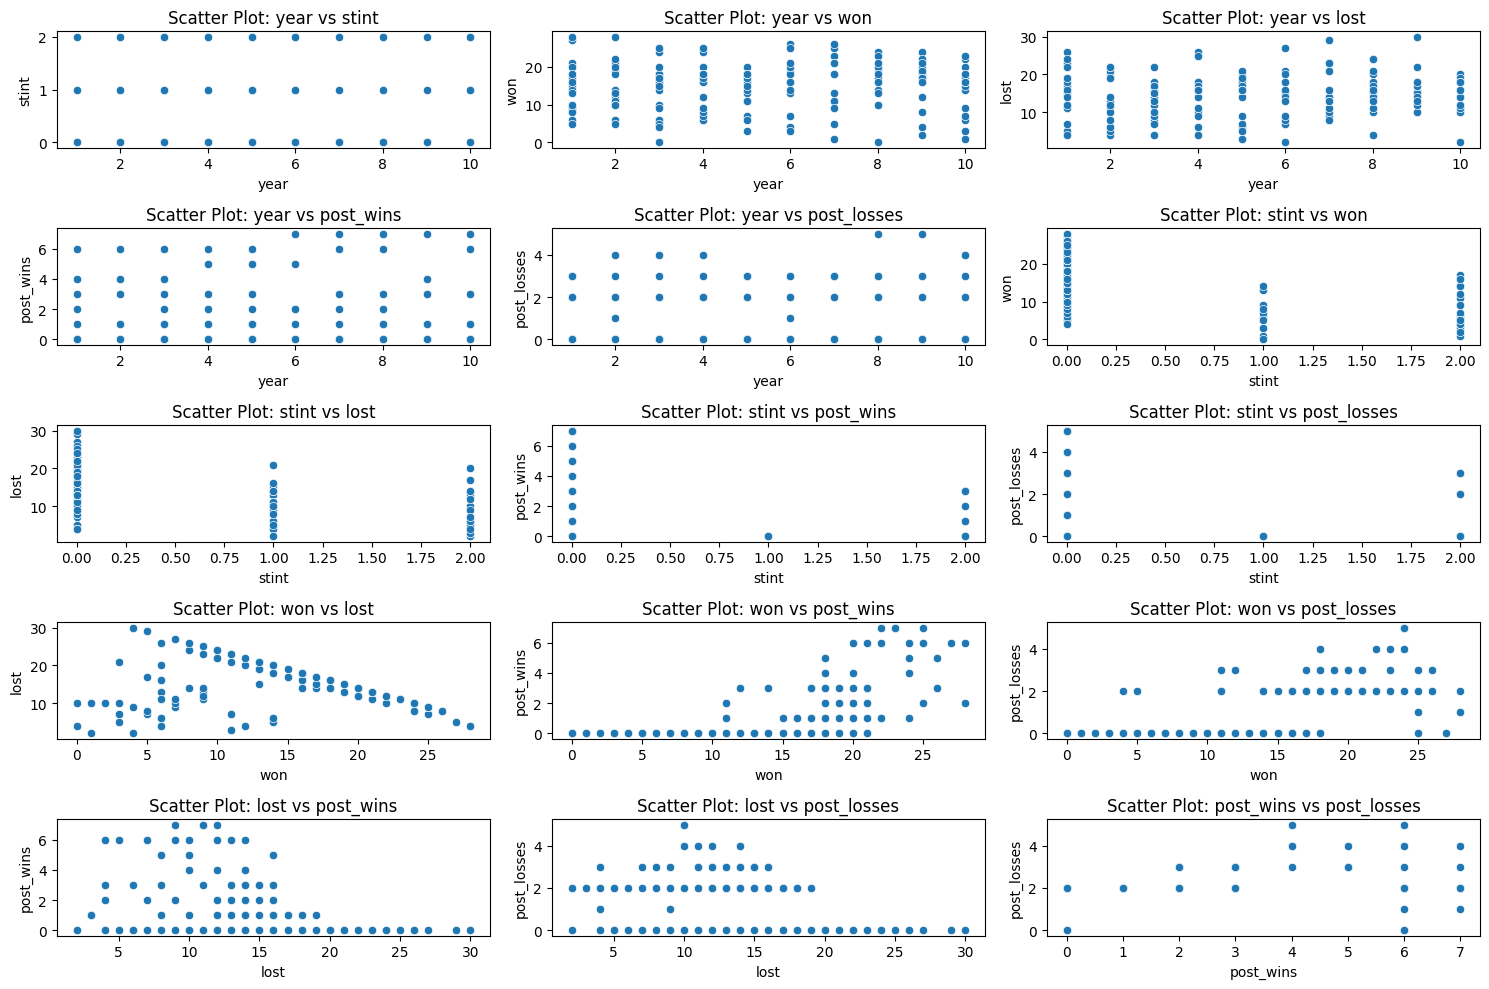

In [10]:
scatter_plot(df.drop(rows2drop))

In [11]:
print(f"Founded {len(rows2drop)} ({round(len(rows2drop) / df.shape[0] * 100, 1)}%) outliers")
df.drop(rows2drop, axis = 0, inplace=True)
print(f"Removed {init_num_rows - df.shape[0]} rows ({round((init_num_rows - df.shape[0]) / init_num_rows * 100, 1)}%)")


Founded 0 (0.0%) outliers
Removed 0 rows (0.0%)


### Adding the Test Dataset...

In [12]:
coaches_test = pd.read_csv('../data/test/coaches.csv')
coaches_test.drop(['lgID'], axis=1, inplace=True)

df = pd.concat([df, coaches_test], axis=0)
df.reset_index(inplace=True, drop=True)

### Shifting the Data...

In [13]:
# Specify the columns to shift (excluding "year" and "tmID")
columns_to_shift = ["won", "lost", "post_wins", "post_losses"]

# Initialize an empty DataFrame to store the shifted data
shifted_data = pd.DataFrame(columns=df.columns)

# Group the data by 'coachID'
grouped = df.groupby('coachID')

# Iterate through each coach's data and shift the specified columns
for coach, coach_data in grouped:
    coach_data[columns_to_shift] = coach_data[columns_to_shift].shift(fill_value=0)
    shifted_data = pd.concat([shifted_data, coach_data])

# Reset the index of the resulting DataFrame
shifted_data = shifted_data.reset_index(drop=True)

# Print the result
print(shifted_data)
df = shifted_data

        coachID year tmID stint   won  lost  post_wins  post_losses
0    adamsmi01w    5  WAS     0   0.0   0.0        0.0          0.0
1    adubari99w    1  NYL     0   0.0   0.0        0.0          0.0
2    adubari99w    2  NYL     0  20.0  12.0        4.0          3.0
3    adubari99w    3  NYL     0  21.0  11.0        3.0          3.0
4    adubari99w    4  NYL     0  18.0  14.0        4.0          4.0
..          ...  ...  ...   ...   ...   ...        ...          ...
171  wintebr01w    6  IND     0  15.0  19.0        0.0          0.0
172  wintebr01w    7  IND     0  21.0  13.0        2.0          2.0
173  wintebr01w    8  IND     0  21.0  13.0        0.0          2.0
174  zierddo99w    8  MIN     0   0.0   0.0        0.0          0.0
175  zierddo99w    9  MIN     0  10.0  24.0        0.0          0.0

[176 rows x 8 columns]


## Save Dataset

In [14]:
if not os.path.exists('../data/clean'):
    os.makedirs('../data/clean')

df.to_csv('../data/clean/coaches.csv', index=False)